In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [103]:
def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

In [51]:
# T1 and T2: extreme of the time interval 
# g: size of the discretization grid
# beta: functional coefficent
# n: number of functional samples
# covariates_kernel of the gaussian process from which beta is sampled

class data_generator:
    def __init__(self, T1, T2, g, beta, n, covariates_kernel, sigma):
        self.T = np.linspace(T1,T2,g)
        self.K = np.fromfunction(np.vectorize(lambda s, t: covariates_kernel(self.T[s], self.T[t])), (g, g), dtype=int)
        self.g = g
        self.n = n
        self.beta = beta
        self.sigma = sigma
    
    def grid(self):
        return self.T

    # return the functional cavariates and the scalar response
    def i_o(self):
        x = np.random.multivariate_normal(np.zeros(self.g), self.K, self.n)
        y = np.fromfunction(np.vectorize(lambda i: integrate(self.T,  x[i,:]*self.beta)+np.random.normal(0,self.sigma,1)), (self.n,), dtype=int)
        return x,y      

In [7]:
# EXAMPLE
# input
a = -3
b = 3
g = 2**7
n = 100
sigma = 1
beta = np.sin(np.linspace(a,b,g)*np.pi/4)

def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)
def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

#generation
data = data_generator(b,a,g,beta,n,covariates_kernel, sigma)
T = data.grid()
x,y = data.i_o()

Text(0.5, 1.0, 'First 3 functional covariates')

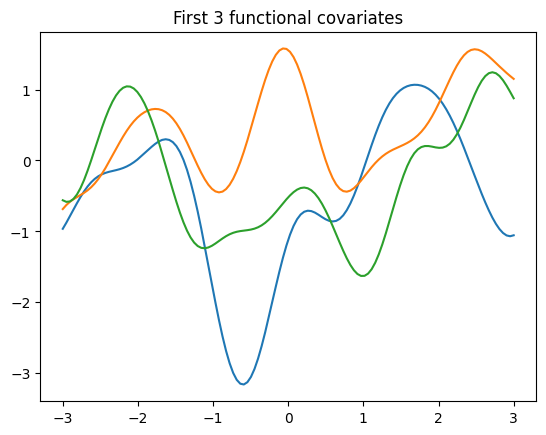

In [12]:
plt.plot(T, x[1])
plt.plot(T, x[2])
plt.plot(T, x[3])
plt.title("First 3 functional covariates")

Assume the folowing model for the data
$$
    Y_i|\beta \sim N(\int_{T} x_i(t)*\beta(t) dt, \sigma^2)
$$
$$
    \beta \sim GP(0,K)
$$
The posterior distribution for $\beta$ is
$$
    \beta|Y \sim GP(m,K^*)
$$
$$
    m(t) = Lx(t)^{'}(\Sigma + \sigma^2I_n)^{-1}Y
$$
$$
    K^*(s,t) = K(s,t) - Lx(s)^{'}(\Sigma + \sigma^2I_n)^{-1}Lx(t)
$$
with
$$
    Lx(t)^{'} = (Lx_1(t), ..., Lx_n(t))
$$
$$
  Lx_i(t) = \int_{T} K(t,s)x_i(s)ds  
$$
$$
    Y = (Y_1,...,Y_n)^{'}
$$
$$
    \Sigma_{ij} = R(x_i, x_j)
$$
$$
    R(x_i, x_j) = \int_{T} \int_{T} K(s,t)*x_i(s)x_j(t)ds dt
$$

In [15]:
class posterior:
    def __init__(self, T, x, y, prior_kernel,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.prior_kernel = prior_kernel
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.sigma = sigma
        self.K = np.fromfunction(np.vectorize(lambda s, t: self.prior_kernel(self.T[s], self.T[t])), (self.g, self.g), dtype=int)
    
    def Lx(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = integrate(self.T,self.K[t, :] * self.x[i,:])
        return L
    
    def R(self,i, j):
        Ri = np.fromfunction(np.vectorize(lambda t: integrate(self.T,self.K[:,t] * self.x[i,:])), (self.g,), dtype=int)
        Rij = integrate(self.T, Ri * self.x[j,:])
        return  Rij
    
    def cov(self):
        return np.fromfunction(np.vectorize(lambda i, j: self.R(i, j)), (self.n, self.n), dtype=int)

    # return m(t) and K*(s,t) for every s,t in T (TODO)
    def posterior_mean_cov(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        def Kstar(s,t):
            cov = self.K[s,t] - np.dot(np.dot(np.transpose(self.Lx(s)),inv),self.Lx(t))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: integrate(T, self.x[i,:]*m)), (self.n,), dtype=int)

In [16]:
# EXAMPLE
p = posterior(T,x,y,prior_kernel,sigma)
m,cov = p.posterior_mean_cov()
fitted = p.fitted_values()

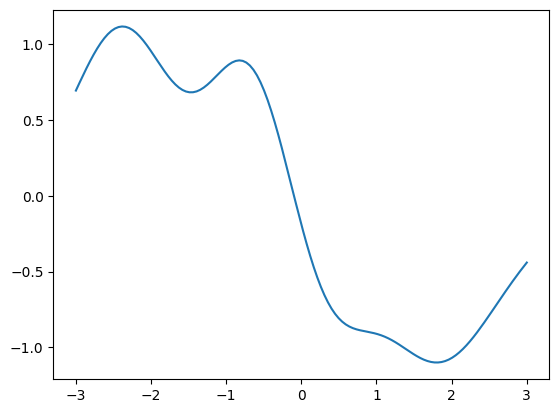

In [18]:
plt.plot(T, m)

In [24]:
np.save('./Project/data/posterior_mean_unconstrained_100.npy', m)
# new_num_arr = np.load('./Project/data/data.npy') # load
np.save('./Project/data/posterior_cov_unconstrained_100.npy', cov)

## Simulations and Fitted Values 

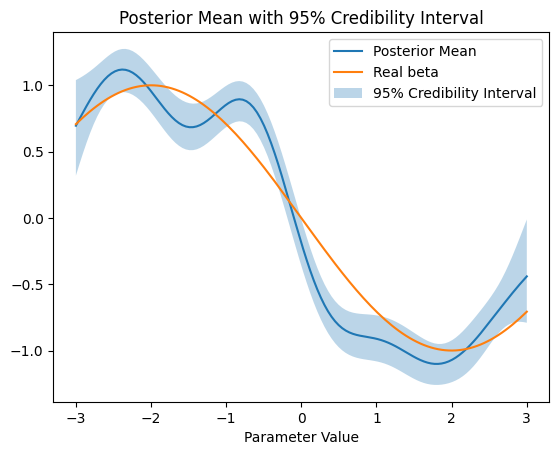

In [35]:
# simulate functional coefficent from beta posterior beta|Y
samples = np.random.multivariate_normal(m, cov, size=1000)

up = np.zeros(m.shape[0])
down = np.zeros(m.shape[0])
for i in range(m.shape[0]):
    # mean, var, std for beta|Y
    mean, var, std = scipy.stats.bayes_mvs(samples[:,i], alpha=0.95)
    mean_estimate, std_estimate = mean.statistic, std.statistic
    # credible interval for beta|Y
    down[i],up[i] = mean_estimate - std_estimate, mean_estimate + std_estimate 

plt.plot(T,m, label='Posterior Mean')
plt.plot(T, beta, label='Real beta')
plt.fill_between(T, down, up, alpha=0.3, label='95% Credibility Interval')

plt.title('Posterior Mean with 95% Credibility Interval')
plt.xlabel('Parameter Value')
plt.legend()
plt.show()

# Test on different Kernel prior

In [104]:
def integrate1(f): # different integration methiod for mean square error calculation
    int = 0;
    for i in np.arange(g-1):
        int = int + (1/2 * (f[i]+f[i+1]) * (b-a)/g)
    return int

## Test using Gaussian Kernel as prior kernel

In [137]:
# Test on Gaussian Kernel

M = 3 # number of dataset
n = [5,10,20,30,40,50] #number of covariates
a = -3
b = 3
g = 2**6
sigma = 1
real_beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)

def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

mse = np.zeros((M, len(n)))
for i in np.arange(M):
    for j in np.arange(len(n)):        
        data = data_generator(b,a,g,real_beta,n[j],covariates_kernel, sigma)
        T = data.grid()
        x,y = data.i_o()
        p = posterior(T,x,y,prior_kernel,sigma)
        m = p.only_mean()
        mse[i,j] = integrate1(np.power(real_beta-m, 2))

mse_mean = np.mean(mse, axis = 0)
mse_std = np.std(mse, axis = 0)

In [138]:
print(mse_mean)
print(mse_std)

[0.93957207 0.88968918 0.47154549 0.32851524 0.20290436 0.13858236]
[0.52661664 0.6297008  0.27714272 0.10282019 0.09115328 0.04681296]


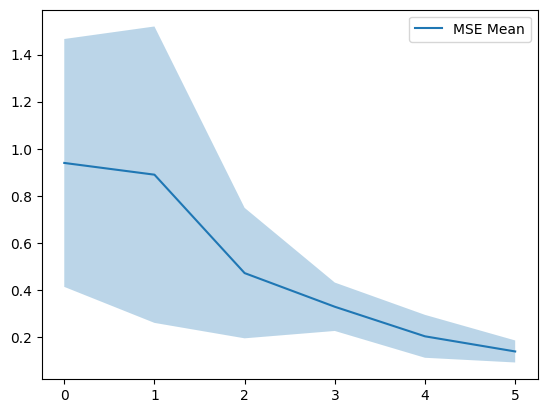

In [139]:
plt.plot(mse_mean, label='MSE Mean')
plt.fill_between(np.arange(len(n)),mse_mean - mse_std, mse_mean + mse_std, alpha=0.3)
plt.legend()
plt.show()

0.08637107613285105

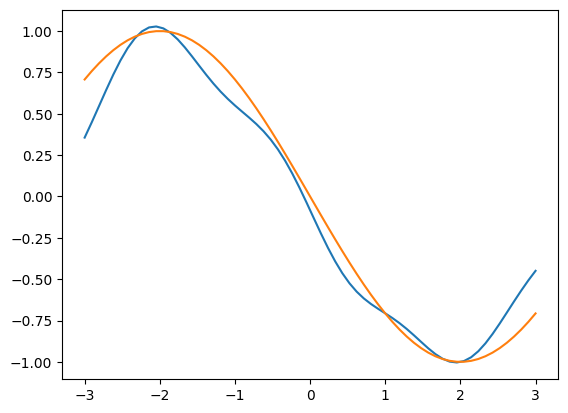

In [140]:
m = p.only_mean()
plt.plot(T, m, label="mean posterior of beta for gaussian kernel")
plt.plot(T, real_beta, label="real beta")
last_mse = integrate1(np.power(real_beta-m, 2))
last_mse

## Test using White Noise Kernel as prior kernel

In [143]:
# White Noise Kernel

M = 3 # number of dataset
n = [5,10,20,30,40,50] #number of covariates
a = -3
b = 3
g = 2**6
sigma = 1
real_beta = np.sin(np.linspace(a,b,g)*np.pi/4)
def covariates_kernel(s,t):
    return np.exp(-2*(t-s)**2)

def prior_kernel(s,t):
    if s==t:
        return sigma
    else:
        return 0
        
mse = np.zeros((M, len(n)))
for i in np.arange(M):
    for j in np.arange(len(n)):        
        data = data_generator(b,a,g,real_beta,n[j],covariates_kernel, sigma)
        T = data.grid()
        x,y = data.i_o()
        p = posterior(T,x,y,prior_kernel,sigma)
        m = p.only_mean()
        mse[i,j] = integrate1(np.power(real_beta-m, 2))

mse_mean = np.mean(mse, axis = 0)
mse_std = np.std(mse, axis = 0)

In [145]:
print(mse_mean)
print(mse_std)

[2.1452335  1.43525378 0.7124945  0.81812975 0.34118694 0.40855054]
[0.71087182 0.63691705 0.44254188 0.33775493 0.01880445 0.04834479]


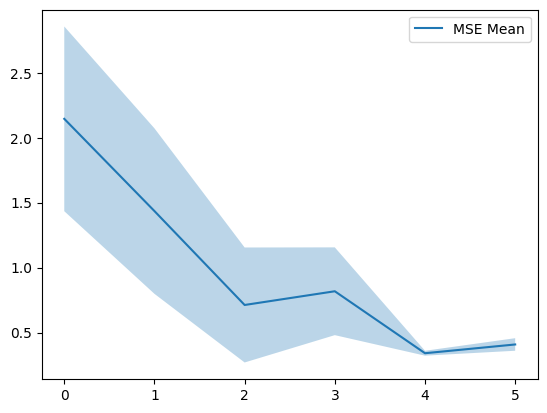

In [146]:
plt.plot(mse_mean, label='MSE Mean')
plt.fill_between(np.arange(len(n)),mse_mean - mse_std, mse_mean + mse_std, alpha=0.3)
plt.legend()
plt.show()

0.4217401763290267

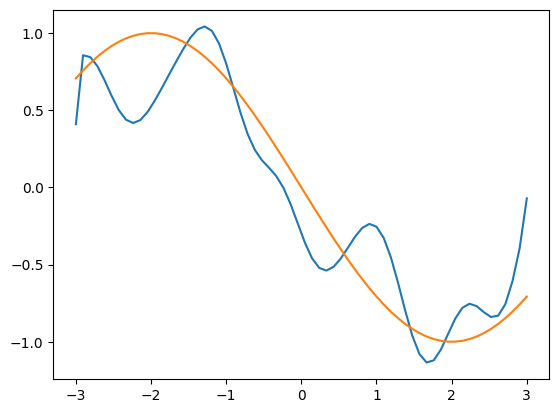

In [150]:
m = p.only_mean()
plt.plot(T, m, label="mean posterior of beta for white noise kernel")
plt.plot(T, real_beta, label="real beta")
last_mse = integrate1(np.power(real_beta-m, 2))
last_mse

## Define a function for systhematic testing on different kernel priors

In [151]:
def test_on_kernel(kernel, M = 3, n = [5,10,20,30,40,50], g = 2**6, sigma = 1 ):
    a = -3
    b = 3
    real_beta = np.sin(np.linspace(a,b,g)*np.pi/4)
    
    def covariates_kernel(s,t):
        return np.exp(-2*(t-s)**2)

    def prior_kernel(s,t):
        return kernel(s,t)
    
    mse = np.zeros((M, len(n)))
    for i in np.arange(M):
        for j in np.arange(len(n)):        
            data = data_generator(b,a,g,real_beta,n[j],covariates_kernel, sigma)
            T = data.grid()
            x,y = data.i_o()
            p = posterior(T,x,y,prior_kernel,sigma)
            m = p.only_mean()
            mse[i,j] = integrate1(np.power(real_beta-m, 2))

    mse_mean = np.mean(mse, axis = 0)
    mse_std = np.std(mse, axis = 0)
    
    return mse_mean, mse_std, real_beta, m #return the latest mean posterior of beta

In [152]:
def plot_result(mse_mean, mse_std, real_beta, m):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    axes[0].plot(mse_mean, label='MSE Mean')
    axes[0].fill_between(np.arange(len(n)),mse_mean - mse_std, mse_mean + mse_std, alpha=0.3)
    axes[0].legend()

    m = p.only_mean()
    axes[1].plot(T, m, label="mean posterior of beta for white noise kernel")
    axes[1].plot(T, real_beta, label="real beta")
    mse[0, 5]
    integrate1(np.power(real_beta-m, 2))

In [153]:
# test on white gaussian kernel
mse_mean, mse_std, real_beta, m = test_on_kernel(prior_kernel)

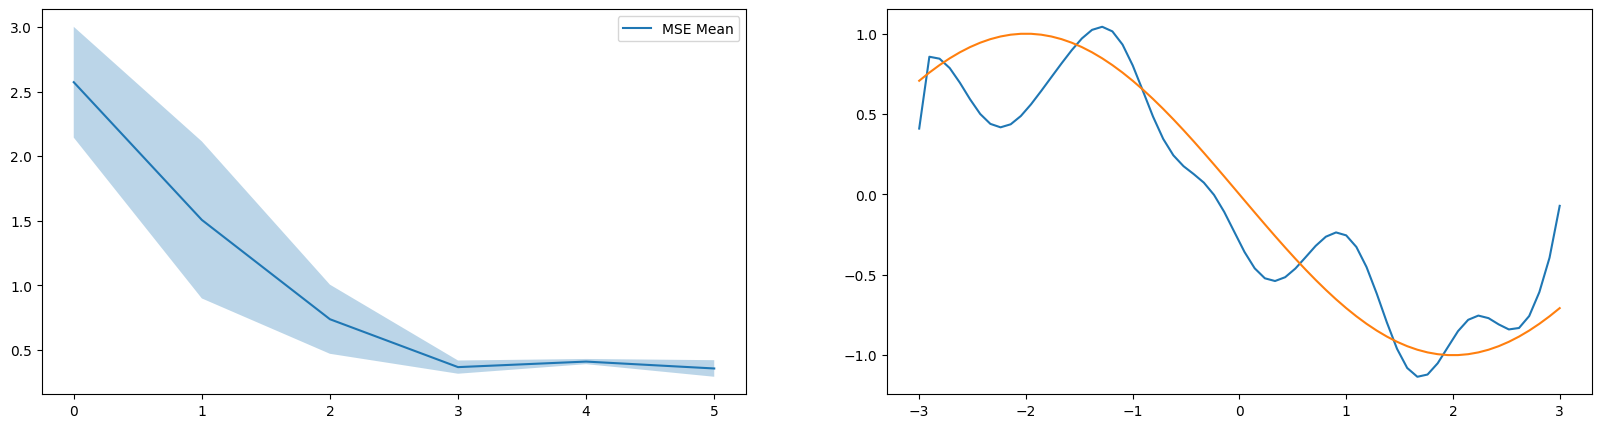

In [154]:
plot_result(mse_mean, mse_std, real_beta, m)